In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
allocs = pd.Series([1/3, 1/3, 1/3, 1], index=['ES', 'GC', 'NQ', 'total'])
#allocs = pd.Series([2/3, 1/3, 1], index=['ES','NQ', 'total'])
cash = 100000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-06-22_12-34_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])

In [4]:
df.groupby('contract').realizedPNL.sum()

contract
ES    18247.0
GC     3521.4
NQ    37350.2
Name: realizedPNL, dtype: float64

In [5]:
df.realizedPNL.sum()

59118.59999999999

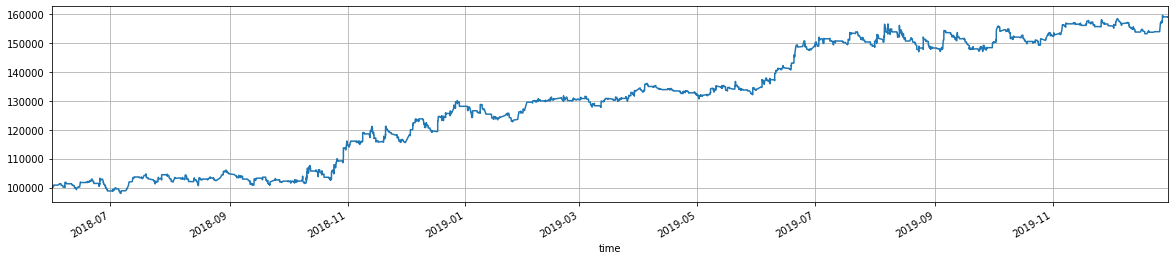

In [6]:
df.cash.plot(figsize=(20,4), grid=True);

In [7]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [8]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     430
 GC     830
 NQ    2188
 Name: action, dtype: int64, 3448)

In [9]:
# trades per day
days = len(by_contract.resample('D').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.743945
 GC    1.435986
 NQ    3.785467
 Name: action, dtype: float64, 5.965397923875432)

In [10]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     903.0
GC    2008.6
NQ    4594.8
Name: commission, dtype: float64

In [11]:
df.commission.sum()

7506.4000000000015

In [12]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.35,8.49,732.15,-384.28,1.91,6.47,415.0
NQ,0.41,34.14,417.54,-237.83,1.76,30.87,1094.0
ES,0.43,84.87,925.42,-543.83,1.70,87.95,215.0
total,0.40,34.29,551.44,-312.48,1.76,33.09,1724.0


In [13]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [14]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

contract,ES,GC,NQ,total
contract,,,,
ES,1.000000,-0.100153,0.163747,0.590559
GC,-0.100153,1.000000,-0.049154,0.515149
NQ,0.163747,-0.049154,1.000000,0.633474
total,0.590559,0.515149,0.633474,1.000000


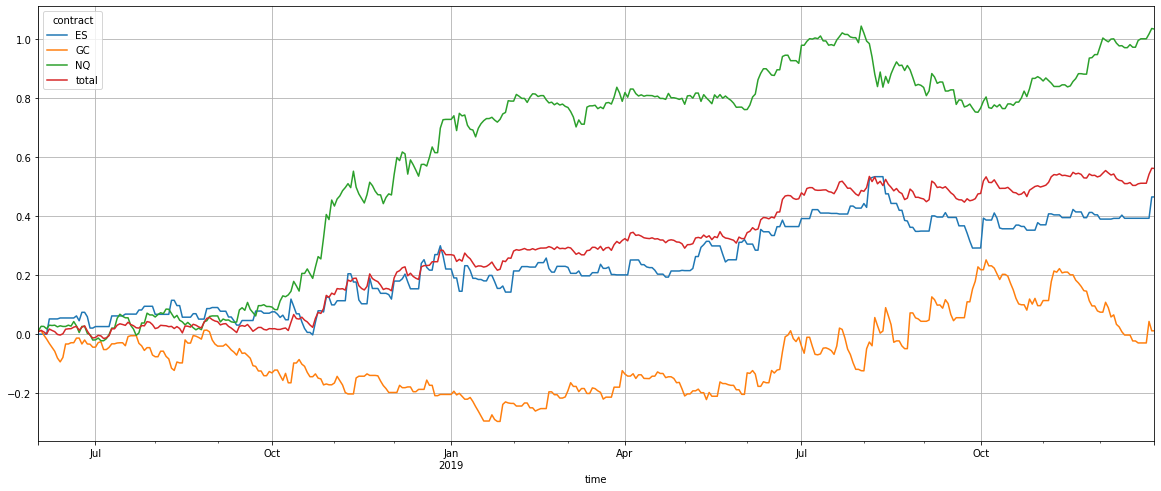

In [15]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

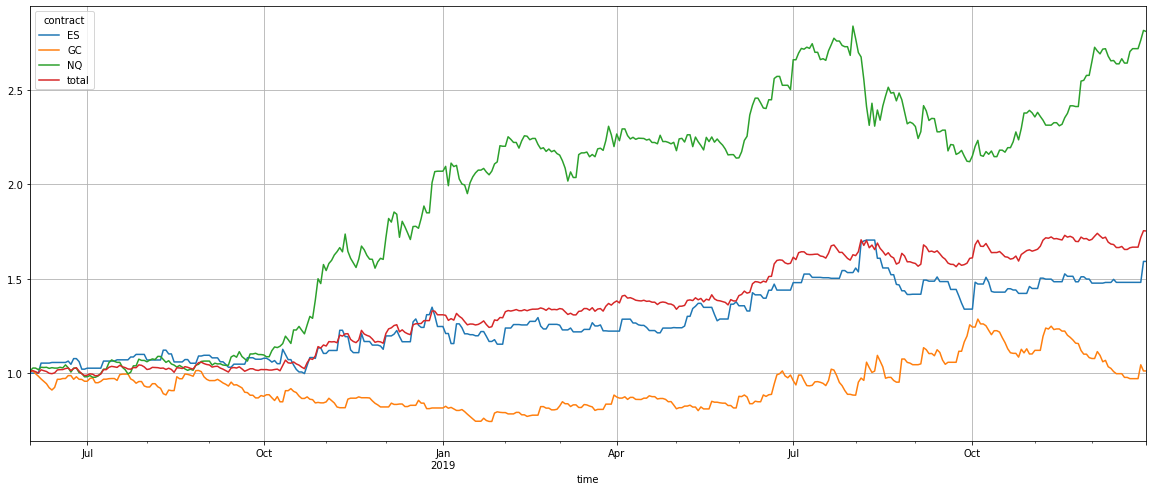

In [16]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [17]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,total
Annual return,0.328595,0.007093,0.880402,0.409317
Cumulative returns,0.591245,0.011622,1.807878,0.752336
Annual volatility,0.322603,0.344208,0.328339,0.192477
Sharpe ratio,1.037881,0.187723,2.087348,1.878662
Calmar ratio,1.531235,0.026682,3.481027,4.908818
Stability,0.869789,0.223438,0.786528,0.948833
Max drawdown,-0.214595,-0.265817,-0.252914,-0.083384
Omega ratio,1.309380,1.039257,1.474877,1.408026
Sortino ratio,2.026397,0.354362,3.790072,3.675040
Skew,2.001370,1.928070,0.814129,1.340756


In [18]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

contract,ES,GC,NQ,total
time,,,,
2018-06-30,2.11,-4.28,-1.94,-1.27
2018-07-31,7.65,-2.61,8.85,4.62
2018-08-31,-0.42,3.78,-0.33,1.24
2018-09-30,-1.91,-8.89,3.24,-2.54
2018-10-31,2.86,-4.39,43.36,12.74
2018-11-30,1.98,-2.56,1.74,0.81
2018-12-31,10.71,-0.66,29.13,12.99
2019-01-31,-7.51,-2.99,6.38,-1.20
2019-02-28,9.11,2.21,-1.76,3.28


In [19]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES        59.0
GC         1.0
NQ       181.0
total     75.0
dtype: float64

In [20]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-08-26 00:37:00,GC,SELL,1557.20,4285.16
2019-10-02 20:46:00,ES,BUY,2891.75,3545.80
2019-08-05 21:20:00,ES,BUY,2841.75,3358.30
2019-08-07 16:12:00,GC,SELL,1513.30,3345.16
2018-11-08 20:42:00,ES,SELL,2795.75,3183.30
...,...,...,...,...
2018-11-21 08:31:00,ES,BUY,2656.00,-1179.20
2019-08-15 21:03:00,ES,BUY,2850.25,-1254.20
2018-12-19 20:28:00,ES,BUY,2561.50,-1279.20
